Reference : https://www.kaggle.com/code/m0sanjith/students-perfomance-analysis-and-prediction

점수 예측이 아닌 시험 준비 여부로 분류 분석 (등급으로 분류분석 하려고 했으나 등급을 나눈 기준 등 컬럼에 대한 설명도 없고 인종과 민족성을 등급으로 나눈 컬럼으로 제거하고 분석에 데이터셋 사용)

In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# model libraries
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

In [3]:
data = pd.read_csv("exams.csv")
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68


In [4]:
data = data.drop(["race/ethnicity"], axis = 1)

In [5]:
data.shape

(1000, 7)

In [6]:
data.isnull().sum()

gender                         0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

Data Visualization

<AxesSubplot:>

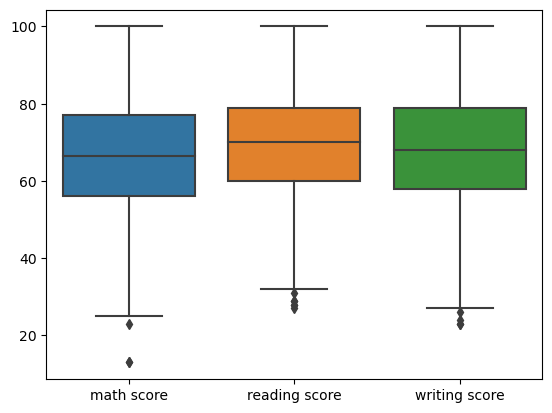

In [7]:
sns.boxplot(data=data[['math score', 'reading score', 'writing score']])

<AxesSubplot:xlabel='test preparation course', ylabel='count'>

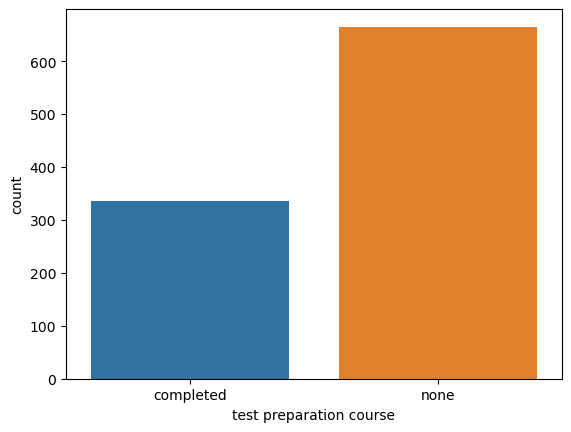

In [8]:
sns.countplot(x=data['test preparation course'])

<AxesSubplot:xlabel='gender', ylabel='count'>

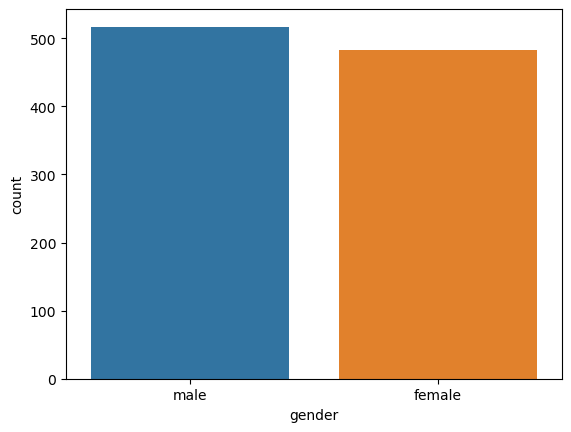

In [9]:
sns.countplot(x=data['gender'])

<AxesSubplot:xlabel='gender', ylabel='math score'>

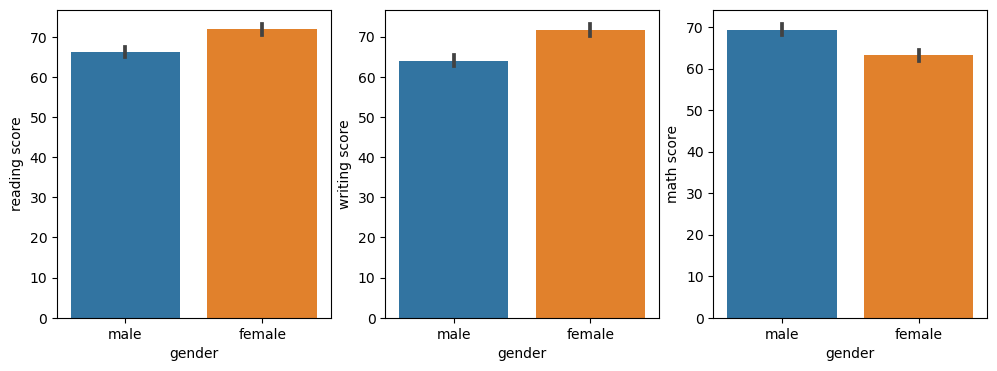

In [10]:
fig, ax =plt.subplots(1,3, figsize=(12,4))
sns.barplot(x=data['gender'],y=data['reading score'], ax=ax[0])
sns.barplot(x=data['gender'],y=data['writing score'],ax=ax[1])
sns.barplot(x=data['gender'],y=data['math score'],ax=ax[2])

<AxesSubplot:xlabel='test preparation course', ylabel='math score'>

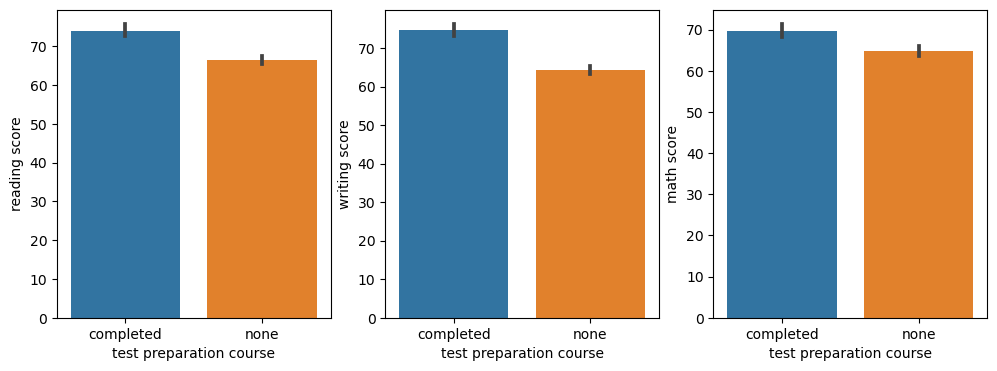

In [11]:
fig, ax =plt.subplots(1,3, figsize=(12,4))
sns.barplot(data=data, x="test preparation course", y='reading score', ax=ax[0])
sns.barplot(data=data, x="test preparation course", y='writing score', ax=ax[1])
sns.barplot(data=data, x="test preparation course", y='math score', ax=ax[2])

### Data Preprocessing
* test preparation course 변수 대체
    * complited : 1
    * none : 0
* math, reading, writing 점수를 합친 total_score 파생변수 생성


In [12]:
data["test_preparation"] = data["test preparation course"].apply(lambda x : 1 if x == "completed" else 0)

In [13]:
data[["test_preparation","test preparation course"]]

,test_preparation,test preparation course
0,1,completed
1,0,none
2,0,none
3,0,none
4,1,completed
...,...,...
995,0,none
996,1,completed
997,0,none
998,0,none


In [14]:
data['total_scores'] = data['math score']+data['reading score']+data['writing score']
data.head()

,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score,test_preparation,total_scores
0,male,high school,standard,completed,67,67,63,1,197
1,female,some high school,free/reduced,none,40,59,55,0,154
2,male,some college,free/reduced,none,59,60,50,0,169
3,male,high school,standard,none,77,78,68,0,223
4,male,associate's degree,standard,completed,78,73,68,1,219


In [15]:
data.groupby("test preparation course")["total_scores"].describe()

,count,mean,std,min,25%,50%,75%,max
test preparation course,,,,,,,,
completed,335.0,218.447761,40.984473,95.0,189.5,221.0,249.0,300.0
none,665.0,195.422556,42.775300,65.0,167.0,196.0,226.0,290.0


<AxesSubplot:>

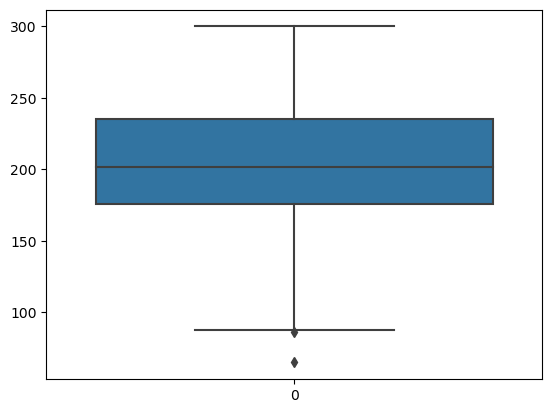

In [16]:
sns.boxplot(data['total_scores'])

### Encoding

In [40]:
data.columns

Index(['gender', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score', 'test_preparation', 'total_scores'],
      dtype='object')

In [42]:
print(data['gender'].unique())
print(data['parental level of education'].unique())
print(data['lunch'].unique())

['male' 'female']
['high school' 'some high school' 'some college' "associate's degree"
 "bachelor's degree" "master's degree"]
['standard' 'free/reduced']


* one hot encoding
    * gender
    * lunch
* label encoding
    * parental level of education

In [43]:
data['gender'] = pd.get_dummies(data=data["gender"], drop_first=True)
data['lunch'] = pd.get_dummies(data=data["lunch"], drop_first=True)

In [46]:
data['parental level of education']=le.fit_transform(data['parental level of education'])

In [47]:
data.head()

,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score,test_preparation,total_scores
0,1,2,1,completed,67,67,63,1,197
1,0,5,0,none,40,59,55,0,154
2,1,4,0,none,59,60,50,0,169
3,1,2,1,none,77,78,68,0,223
4,1,0,1,completed,78,73,68,1,219


### Splitting the dataset for training and testing the Model

In [48]:
data.columns

Index(['gender', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score', 'test_preparation', 'total_scores'],
      dtype='object')

In [49]:
X = data[['gender', 'parental level of education', 'lunch', 'math score', 'reading score',
       'writing score', 'total_scores']]

In [50]:
y = data['test_preparation']

In [51]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, stratify=y, random_state=42)

In [52]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 7), (200, 7), (800,), (200,))

Text(0.5, 1.0, 'test')

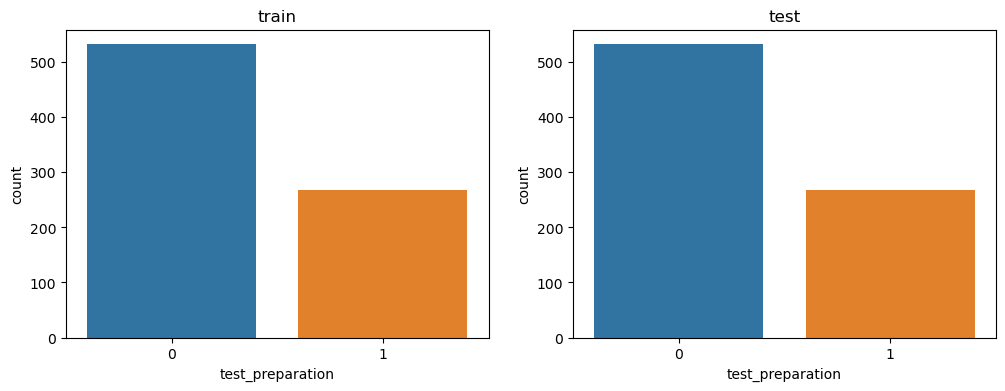

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
sns.countplot(x=y_train, ax=ax[0]).set_title("train")
sns.countplot(x=y_train, ax=ax[1]).set_title("test")

### Modeling

In [117]:
model = RandomForestClassifier(random_state=42,n_estimators = 500)
model

RandomForestClassifier(n_estimators=500, random_state=42)

In [119]:
param_distributions = {"max_depth" : np.random.randint(3, 20, 10) ,
                      "max_features" : np.random.uniform(0.8, 1, 10) }
clfr = RandomizedSearchCV(model,
                          param_distributions=param_distributions,
                          n_iter=10,
                          cv=5, 
                          n_jobs=-1,
                          random_state=42, 
                          scoring="accuracy", verbose=1)
clfr.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_estimators=500,
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': array([ 3, 13, 19,  9, 14,  6, 18, 15,  7, 14]),
                                        'max_features': array([0.86532162, 0.91992253, 0.96874427, 0.97356312, 0.86071735,
       0.85441731, 0.89080628, 0.80550532, 0.93875588, 0.90467839])},
                   random_state=42, scoring='accuracy', verbose=1)

In [120]:
clfr.best_estimator_

RandomForestClassifier(max_depth=6, max_features=0.9735631226998575,
                       n_estimators=500, random_state=42)

In [121]:
clfr.best_params_

{'max_features': 0.9735631226998575, 'max_depth': 6}

In [122]:
pd.DataFrame(clfr.cv_results_).nsmallest(5, "rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,1.039045,0.012434,0.056212,0.005568,0.973563,6,"{'max_features': 0.9735631226998575, 'max_dept...",0.69375,0.73125,0.7,0.67500,0.71250,0.70250,0.018792,1
9,0.759984,0.154092,0.043417,0.009724,0.865322,3,"{'max_features': 0.8653216238583781, 'max_dept...",0.70625,0.68750,0.7,0.70000,0.71250,0.70125,0.008292,2
0,1.087939,0.004479,0.067966,0.003873,0.973563,7,"{'max_features': 0.9735631226998575, 'max_dept...",0.70625,0.73125,0.7,0.66875,0.69375,0.70000,0.020156,3
7,1.092008,0.017779,0.059266,0.009000,0.865322,7,"{'max_features': 0.8653216238583781, 'max_dept...",0.70625,0.73125,0.7,0.66875,0.69375,0.70000,0.020156,3
5,1.162235,0.018527,0.055667,0.007062,0.904678,9,"{'max_features': 0.9046783948318446, 'max_dept...",0.67500,0.71250,0.7,0.69375,0.68750,0.69375,0.012500,5


In [123]:
# 데이터를 머신러닝 모델로 학습(fit)합니다.
best_model = clfr.best_estimator_.fit(X_train, y_train)
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_features=0.9735631226998575,
                       n_estimators=500, random_state=42)

In [124]:
# 데이터를 머신러닝 모델로 예측(predict)합니다.
y_predict = best_model.predict(X_test)
y_predict

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0], dtype=int64)

In [127]:
accuracy_score(y_test, y_predict)

0.735